11 앙상블 모델

In [1]:
from data_processing import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# 데이터 준비 및 저장
prepare_and_store_data("data_ml.csv")

# 데이터 가져오기
data_ml = get_data_ml()
training_sample = get_training_sample()
testing_sample = get_testing_sample()
features = get_features()
features_short = get_features_short()

# 결과 확인
print("Data ML Shape:", data_ml.shape)
print("Training Sample Shape:", training_sample.shape)
print("Testing Sample Shape:", testing_sample.shape)
print("Features:", features_short)


Data ML Shape: (536672, 103)
Training Sample Shape: (396256, 103)
Testing Sample Shape: (140416, 103)
Features: ['Div_Yld', 'Eps', 'Mkt_Cap_12M_Usd', 'Mom_11M_Usd', 'Ocf', 'Pb', 'Vol1Y_Usd']


In [2]:
stock_ids_short = []
stock_days = []
separation_date = "2014-01-15"
idx_train = data_ml.index[(data_ml['date']<separation_date)].tolist()
idx_test = data_ml.index[(data_ml['date']>=separation_date)].tolist()

training_sample = data_ml[data_ml.index.isin(idx_train)]
testing_sample = data_ml[data_ml.index.isin(idx_test)]

# 패널티 회귀 (chap 5)
from sklearn.linear_model import ElasticNet

y_penalized_train = training_sample['R1M_Usd'].values
X_penalized_train = training_sample[features].values
model = ElasticNet(alpha=0.1, l1_ratio=0.1)
fit_pen_pred = model.fit(X_penalized_train, y_penalized_train)

# 단순 트리 (chap 6)
from sklearn import tree
X = data_ml.iloc[:, 3:95]
y = data_ml['R1M_Usd']

fit_tree = tree.DecisionTreeRegressor(
    min_samples_split=8000,
    max_depth= 3,
    ccp_alpha= 0.000001,
    min_samples_leaf= 3500
    )
fit_tree.fit(X, y)

# 랜덤 포레스트 (chap 6)
from sklearn.ensemble import RandomForestRegressor
fit_RF = RandomForestRegressor(n_estimators= 40,
                               criterion='squared_error',
                               min_samples_split=250,
                               bootstrap=True,
                               max_features=30,
                               max_samples=10000
                               )
y_train = training_sample['R1M_Usd'].values
X_train = training_sample[features].values

fit_RF.fit(X_train, y_train)

# xgboost (chap 6)
import xgboost as xgb
mono_const="(0, 0, -1, 1, 0, -1, 0)"
train_matrix_xgb = xgb.DMatrix(X_train, y_train)
params={'eta':0.3, #학습률
        'objective':"reg:squarederror", #목적함수 
        'max_depth':4, #트리의 최고 깊이
        'subsample':0.6, #샘플 중 무작위적으로 60%를 선택해 훈련
        'colsample_bytree':0.7, #예측 인자 중 무작위적으로 70%를 선택해 훈련
        'lambda':1, #나뭇잎 값에 대한 규제화
        'gamma':0.1, #나뭇잎 개수에 대한 규제화
        'nrounds':30, #사용한 트리 개수
        'monotone_constraints':mono_const, #단조성 제약 조건
        'rate_drop':0.1, #DART를 위한 드롭률
        'verbose':0} #메시지 없음
fit_xgb = xgb.train(params, train_matrix_xgb)

# 피드백포워드 신경망 (chap 7)
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from plot_keras_history import show_history, plot_history


NN_test_features = testing_sample[features].values
NN_test_labels = testing_sample['R1M_Usd'].values

model = keras.Sequential()
model.add(layers.Dense(16, activation="relu", input_shape=(len(features),)))
model.add(layers.Dense(8,activation="tanh"))
model.add(layers.Dense(1))
def custom_loss(y_true, y_pred):
    loss = tf.reduce_mean(
        tf.square(y_pred - tf.reduce_mean(y_pred))) -5 * tf.reduce_mean(
        (y_true - tf.reduce_mean(y_true)) * (y_pred - tf.reduce_mean(y_pred)))
    return loss

model.compile(optimizer='RMSprop',
              loss=custom_loss,
              metrics=['MeanAbsoluteError'])
model.summary()

fit_NN = model.fit(
    X_train,
    y_train,
    batch_size=512,
    epochs=10,
    validation_data=(NN_test_features,NN_test_labels),
    verbose=False
)

c:\ProgramData\miniconda3\envs\tensor\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:20:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "nrounds", "rate_drop", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
c:\ProgramData\miniconda3\envs\tensor\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │         1,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,633 (6.38 KB)

 Trainable params: 1,633 (6.38 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
"""
stock_ids_short = []
stock_days = []

# 각 주식별 데이터 포인트 개수 세기
stock_ids = data_ml['stock_id'].unique()
stock_days = data_ml[['date', 'stock_id']].groupby(
    ['stock_id']).count().reset_index()

# 데이터가 모두 있는 주식을 리스트로 변환
stock_ids_short = stock_days.loc[
    stock_days['date'] == (stock_days['date'].max())]
stock_ids_short = stock_ids_short['stock_id'].unique()
is_stock_ids_short = data_ml['stock_id'].isin(stock_ids_short)
data_ml_unique = data_ml[is_stock_ids_short].drop_duplicates(subset=['date', 'stock_id'])


returns = data_ml_unique[is_stock_ids_short].pivot(
    index='date', columns='stock_id', values='R1M_Usd'
)

data_rnn = data_ml[data_ml['stock_id'].isin(stock_ids_short)]
training_sample_rnn = data_rnn[data_rnn['date']<separation_date]
testing_sample_rnn = data_rnn[data_rnn['date']>separation_date]

nb_stocks = len(stock_ids_short)
nb_feats = len(features)
nb_dates_train = training_sample_rnn.shape[0] // nb_stocks
nb_dates_test = testing_sample_rnn.shape[0] // nb_stocks

nn_train_features = training_sample_rnn[features].values
nn_test_features = testing_sample_rnn[features].values
nn_train_labels = training_sample_rnn['R1M_Usd'].values
nn_test_labels = testing_sample_rnn['R1M_Usd'].values

# 데이터 변환: nn_train_features를 (nb_dates_train, nb_stocks, nb_feats) 형식으로 재구성
train_features_rnn = np.reshape(nn_train_features, (nb_dates_train, nb_stocks, nb_feats))
test_features_rnn = np.reshape(nn_test_features, (nb_dates_test, nb_stocks, nb_feats))

# GRU에 맞게 배치 차원으로 변환: (nb_stocks, nb_dates_train, nb_feats)
train_features_rnn = train_features_rnn.transpose(1, 0, 2)  # 
test_features_rnn = test_features_rnn.transpose(1, 0, 2)  # 

# 레이블도 동일한 형식으로 변환
train_labels_rnn = np.reshape(nn_train_labels, (nb_stocks, nb_dates_train, 1))
test_labels_rnn = np.reshape(nn_test_labels, (nb_stocks, nb_dates_test, 1))

model_RNN = keras.Sequential()
model_RNN.add(layers.GRU(16, input_shape= (nb_dates_train, nb_feats),
                         activation='tanh',
                         return_sequences=True))
model_RNN.add(layers.Dense(1))
model_RNN.compile(optimizer='RMSprop', #손실 = 이차
                  loss='mse', # 역전파
                  metrics=['MeanAbsoluteError'])

fit_RNN = model_RNN.fit(train_features_rnn,
                        train_labels_rnn,
                        epochs = 10,
                        batch_size = nb_stocks,
                        verbose=False)
show_history(fit_RNN)
"""

NN 모델 값이 너무 이질적으로 나와.. 보류

In [7]:
err_pen_train = fit_pen_pred.predict(
    X_penalized_train) - training_sample['R1M_Usd'] #회귀
err_tree_train = fit_tree.predict(
    training_sample[features]) - training_sample['R1M_Usd'] #트리
err_RF_train = fit_RF.predict(
    training_sample[features]) - training_sample['R1M_Usd'] # 랜덤 포레스트
err_XGB_train = fit_xgb.predict(
    train_matrix_xgb) - training_sample['R1M_Usd'] # XGBoost
err_NN_train = model.predict(
    training_sample[features]) - training_sample['R1M_Usd'].values.reshape((-1,1)) # 신경망
"""
E = pd.concat(
    [err_pen_train, err_tree_train, err_RF_train, err_XGB_train, pd.DataFrame(err_NN_train)], axis=1)
E = E.set_axis(['Pen_reg', 'Tree', 'RF', 'XGB', 'NN'], axis=1)
E.corr()
"""
E = pd.concat(
    [err_pen_train, err_tree_train, err_RF_train, err_XGB_train], axis=1)
E = E.set_axis(['Pen_reg', 'Tree', 'RF', 'XGB'], axis=1)
E.corr()

c:\ProgramData\miniconda3\envs\tensor\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


12383/12383 ━━━━━━━━━━━━━━━━━━━━ 5s 423us/step


,Pen_reg,Tree,RF,XGB
Pen_reg,1.000000,0.998251,0.995626,0.975584
Tree,0.998251,1.000000,0.996458,0.976957
RF,0.995626,0.996458,1.000000,0.976550
XGB,0.975584,0.976957,0.976550,1.000000


In [13]:
E.corr().mean()

Pen_reg    0.992365
Tree       0.992916
RF         0.992158
XGB        0.982273
dtype: float64

In [9]:
abs(E).mean()

Pen_reg    0.083459
Tree       0.083668
RF         0.083397
XGB        0.083370
dtype: float64

In [10]:
w_ensemble = np.linalg.inv((E.T.values@E.values))@np.ones(4)
w_ensemble /= np.sum(w_ensemble)
w_ensemble

array([-0.31626807, -0.96003017,  0.31690191,  1.95939632])

In [20]:
y_test = testing_sample['R1M_Usd'].values
X_test = testing_sample[features].values
test_matrix_xgb = xgb.DMatrix(X_test)
X_penalized_test = testing_sample[features].values


err_pen_test = fit_pen_pred.predict(
    X_penalized_test) - testing_sample['R1M_Usd'] #회귀
err_tree_test = fit_tree.predict(
    testing_sample[features]) - testing_sample['R1M_Usd'] #트리
err_RF_test = fit_RF.predict(
    testing_sample[features]) - testing_sample['R1M_Usd'] #랜덤 포레스트
err_XGB_test = fit_xgb.predict(
    test_matrix_xgb) - testing_sample['R1M_Usd'] #XGBoost
#err_NN_test = model.predict(
#    testing_sample[features_short]) - testing_sample['R1M_Usd'].values.reshape((-1,1))

E_test = pd.concat(
    [err_pen_test, err_tree_test, err_RF_test, err_XGB_test], axis=1)
E_test = E_test.set_axis(['Pen_reg', 'Tree', 'RF', 'XGB'], axis=1)
abs(E_test).mean()

c:\ProgramData\miniconda3\envs\tensor\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Pen_reg    0.066182
Tree       0.066505
RF         0.067373
XGB        0.067628
dtype: float64

In [21]:
err_EW_test = np.mean(np.abs(E_test.mean(axis=1)))
print(f'equally weight combination: {err_EW_test}')

equally weight combination: 0.06663224051447005


최적 가중치 테스트

In [23]:
err_opt_test = np.mean(np.abs(E_test.values@w_ensemble))
print(f'Optimal unconstrained combination: {err_opt_test}')
# 최적 솔루션이지만, 결과는 좋지 않다. 휴리스틱한 균등 결합보다 성능이 떨어진다.

Optimal unconstrained combination: 0.07010721140454386


In [24]:
from cvxopt import matrix, solvers #이차 계획법을 위한 라이브러리
sigma = E.T.values@E.values #스케일링되지 않은 공분산 행렬
nb_mods = 4 #모델 개수

# 대칭적 이차-비용 행렬
Q = 2*matrix(sigma, tc="d")
# 이차 비용 벡터
p = matrix(np.zeros(nb_mods), tc="d")
# 선형 부등식 제약 행렬
G = matrix(-np.eye(nb_mods), tc="d")
# 선형 부등식 제약 벡터
h = matrix(np.zeros(nb_mods), tc="d")
# 선형 등식 제약 조건을 위한 행렬
A = matrix(np.ones(nb_mods), (1, nb_mods))
# 선형 등식 제약 조건을 위한 벡터
b = matrix(1.0)
# 솔루션
w_const = solvers.qp(Q, p, G, h, A, b)
print(w_const['x'])

     pcost       dcost       gap    pres   dres
 0:  9.2856e+03  9.2875e+03  2e+01  4e+00  6e+00
 1:  9.2858e+03  9.2937e+03  7e+00  2e+00  3e+00
 2:  9.2935e+03  9.3202e+03  9e+00  1e+00  2e+00
 3:  9.3333e+03  9.3955e+03  4e+01  8e-01  1e+00
 4:  9.3275e+03  9.5250e+03  9e+01  8e-01  1e+00
 5:  9.5492e+03  9.7733e+03  7e+00  2e-01  3e-01
 6:  9.8307e+03  9.8284e+03  2e+00  1e-16  1e-11
 7:  9.8285e+03  9.8285e+03  2e-02  1e-19  5e-12
 8:  9.8285e+03  9.8285e+03  2e-04  2e-16  6e-12
Optimal solution found.
[ 2.17e-08]
[ 8.90e-08]
[ 1.08e-07]
[ 1.00e+00]



In [ ]:
#가중치 희소 / 하나의 모델에 치중

11.2 스택 앙상블

저차원 신경망 생성

In [25]:
model_stack = keras.Sequential()
model_stack.add(layers.Dense(8, activation="relu", input_shape = (nb_mods,)))
model_stack.add(layers.Dense(4, activation="tanh"))
model_stack.add(layers.Dense(1))

c:\ProgramData\miniconda3\envs\tensor\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [26]:
model_stack.compile(optimizer='RMSprop',
                    loss='mse',
                    metrics=['MeanAbsoluteError'])
model_stack.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81 (324.00 B)

 Trainable params: 81 (324.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/12
774/774 ━━━━━━━━━━━━━━━━━━━━ 1s 831us/step - MeanAbsoluteError: 0.0835 - loss: 0.0256 - val_MeanAbsoluteError: 0.0672 - val_loss: 0.0365
Epoch 2/12
774/774 ━━━━━━━━━━━━━━━━━━━━ 1s 683us/step - MeanAbsoluteError: 0.0837 - loss: 0.0379 - val_MeanAbsoluteError: 0.0678 - val_loss: 0.0363
Epoch 3/12
774/774 ━━━━━━━━━━━━━━━━━━━━ 1s 691us/step - MeanAbsoluteError: 0.0834 - loss: 0.0250 - val_MeanAbsoluteError: 0.0680 - val_loss: 0.0362
Epoch 4/12
774/774 ━━━━━━━━━━━━━━━━━━━━ 1s 702us/step - MeanAbsoluteError: 0.0836 - loss: 0.0261 - val_MeanAbsoluteError: 0.0682 - val_loss: 0.0361
Epoch 5/12
774/774 ━━━━━━━━━━━━━━━━━━━━ 1s 668us/step - MeanAbsoluteError: 0.0837 - loss: 0.0274 - val_MeanAbsoluteError: 0.0684 - val_loss: 0.0362
Epoch 6/12
774/774 ━━━━━━━━━━━━━━━━━━━━ 1s 675us/step - MeanAbsoluteError: 0.0838 - loss: 0.0309 - val_MeanAbsoluteError: 0.0686 - val_loss: 0.0361
Epoch 7/12
774/774 ━━━━━━━━━━━━━━━━━━━━ 1s 698us/step - MeanAbsoluteError: 0.0834 - loss: 0.0243 - val_MeanAbsol

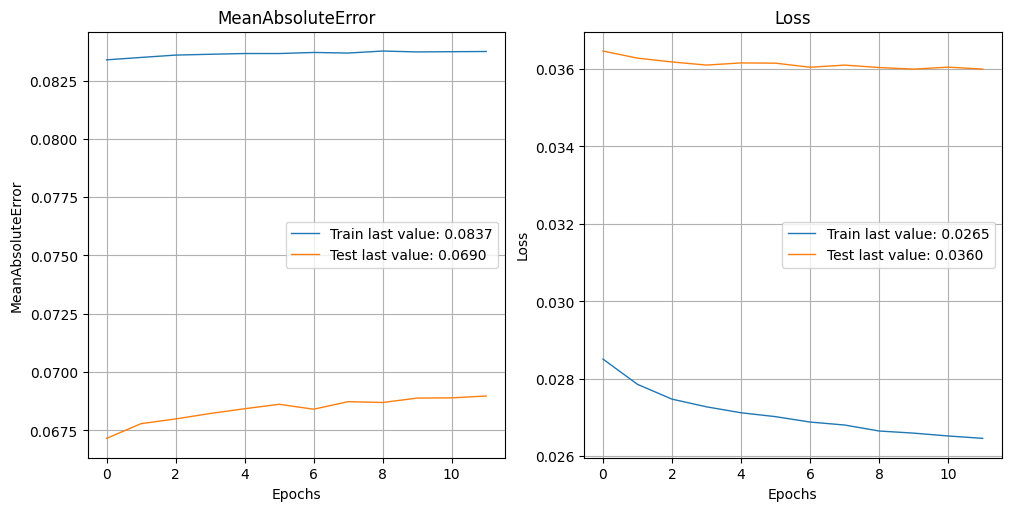

In [27]:
NN_train_features = training_sample[features].values
NN_train_labels = training_sample['R1M_Usd'].values
NN_test_features = testing_sample[features].values
NN_test_labels = testing_sample['R1M_Usd'].values

y_tilde = E.values+np.tile(
    training_sample['R1M_Usd'].values.reshape(-1,1), nb_mods)
y_test = E_test.values+np.tile(
    testing_sample['R1M_Usd'].values.reshape(-1,1), nb_mods)
fit_NN_stack = model_stack.fit(y_tilde,
                               NN_train_labels,
                               batch_size=512,
                               epochs=12,
                               verbose=1,
                               validation_data=(y_test, NN_test_labels))
show_history(fit_NN_stack)

In [ ]:
# 실망 스러운 성능
# 학습 곡선이 평평- 역전파 라운드 쓸모 X,학습이 거의 가치를 추가하지 못함
# 머신러닝의 새로운 최상위 레이어가 원래 예측을 향상시키지 못한다는 의미.

# -> 모든 머신러닝 엔진이 동일한 패턴을 포착하는 것으로 보임. (선형, 비선형 모두 성능 개선 X)

11.3 확장